## Run SCARP to obtain cell embedding for better clustering cells

In [1]:
import sys
sys.path.append('../Scarp/')

from downstream import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(1)

random_state = 1
beta = 5000
m = 1.5
merge_thre = 3000

In [3]:
data_names = ['Forebrain', 'GM12878vsHL', 'Leukemia',
              'Breast_Tumor', 'GM12878vsHEK', 'InSilico',
              'Sox10KD', 'blood2K', 'Splenocyte']

In [4]:
data_name = data_names[5]

In [5]:
print('\n++++++++++++++++++++ %s ++++++++++++++++++++++++' % data_name)

data = sc.read_h5ad('./Processed Data/' + data_name + '.h5ad')
Cells = data.obs.index
Cells_num, Peaks_num = data.X.shape
N = Cells_num + Peaks_num
labels = data.obs['celltype'].astype('category')
if data_name == 'GM12878vsHEK' or data_name == 'GM12878vsHL':
    cluster_num = 2
else:
    cluster_num = np.unique(labels).shape[0]

print('Number of Peaks:', Peaks_num)
print('Number of Cells:', Cells_num)
print('Number of labels: ', cluster_num)


++++++++++++++++++++ InSilico ++++++++++++++++++++++++
Number of Peaks: 13668
Number of Cells: 828
Number of labels:  6


In [6]:
t, diffusion_mat = SCARP(data=data,
                         m=m,
                         merge_thre=merge_thre,
                         beta=beta,
                         peak_loc=True)


%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Started (without parallel computing)%%%%%%%%%%%%%%%%%%%%%%%%%%
       ====================== Chr1~5: 4304 Peaks ========================
       ====================== Chr6~10: 3090 Peaks ========================
       ====================== Chr11~16: 3233 Peaks ========================
       ====================== Chr17~24: 3041 Peaks ========================
%%%%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Finished %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Running time: 19.73639678955078s

Matrix Splicing...........
Splicing time: 0.44666075706481934s


In [7]:
if data_name == 'Breast_Tumor':
    k = 5
else:
    if Peaks_num > 50000:
        k = std_plot(data=diffusion_mat,
                     title=data_name,
                     max_k=100,
                     plot_std=True,
                     save_file='./Results/Kept component of ' + data_name + '.svg')
    else:
        k = std_plot(data=diffusion_mat,
                     title=data_name,
                     max_k=50,
                     plot_std=True,
                     save_file='./Results/Kept component of ' + data_name + '.svg')

In [8]:
cell_mat = SCARP_cell_embedding(diffusion_mat=diffusion_mat,
                                kept_comp=k)

Cells_df = pd.DataFrame(cell_mat,
                        index=Cells,
                        columns=['feature' + str(i + 1) for i in range(cell_mat.shape[1])])

adata_cell = sc.AnnData(Cells_df)
adata_cell.var_names_make_unique()
adata_cell.obs['label'] = labels

### plot UMAP

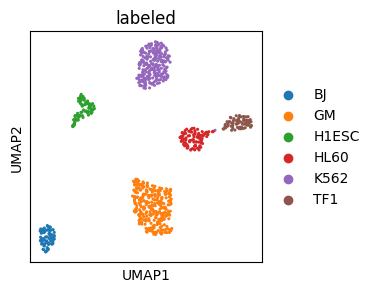

In [9]:
sc.pp.neighbors(adata_cell, use_rep='X', random_state=random_state)
sc.tl.umap(adata_cell, random_state=random_state)
fig1, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='label', title='labeled', s=20, ax=ax, save='_' + data_name + '_labeled.svg')

### plot TSNE

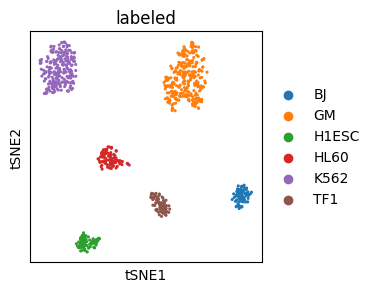

In [10]:
sc.tl.tsne(adata_cell, use_rep='X', random_state=random_state)
fig2, ax = plt.subplots(figsize=(3, 3))
sc.pl.tsne(adata_cell, color='label', title='labeled', s=20, ax=ax, save='_' + data_name + '_labeled.svg')

### plot louvain

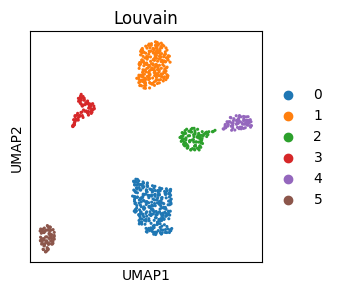

In [11]:
[warning, adata_cell] = getNClusters_Louvain(adata_cell, cluster_num, range_max=3)
if warning == 0:
    print('Wrong for Louvain! ')
fig3, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='louvain', title='Louvain', s=20, ax=ax, save='_' + data_name + '_louvain.svg')

### compute silhouette score

In [12]:
silhouette_UMAP = metrics.silhouette_score(adata_cell.obsm['X_umap'], labels)
silhouette_TSNE = metrics.silhouette_score(adata_cell.obsm['X_tsne'], labels)
print("Silhouette score under UMAP: " + str(silhouette_UMAP))
print("Silhouette score under TSNE: " + str(silhouette_TSNE))

Silhouette score under UMAP: 0.75828147
Silhouette score under TSNE: 0.8117751


### compute ARI/NMI score

In [13]:
if data_name == 'GM12878vsHEK' or data_name == 'GM12878vsHL':
    apart_mixed_label = adata_cell.obs['label'].iloc[np.where(adata_cell.obs['label'] != 'Mixed')].astype(
        'str').astype('category')
    apart_mixed_louvain = adata_cell.obs['louvain'].iloc[np.where(adata_cell.obs['label'] != 'Mixed')].astype(
        'str').astype('category')
else:
    apart_mixed_label = adata_cell.obs['label']
    apart_mixed_louvain = adata_cell.obs['louvain']

score = pd.DataFrame({'ARI': adjusted_rand_score(apart_mixed_louvain, apart_mixed_label),
                      'NMI': normalized_mutual_info_score(apart_mixed_louvain, apart_mixed_label)
                      },
                     index=['louvain'])

print(score)

              ARI       NMI
louvain  0.994246  0.991003


### plot confusion matrix

In [14]:
if data_name == 'GM12878vsHL':
    name = dict(zip(['GM12878', 'HL60', 'Mixed'], range(3)))
elif data_name == 'GM12878vsHEK':
    name = dict(zip(['GM12878', 'HEK293T', 'Mixed'], range(3)))
else:
    name = dict(zip(set(labels), range(cluster_num)))

Cluster_louvain_mat = confusion_matrix(adata_cell.obs['louvain'].astype(int), [name[i] for i in labels])

if data_name == 'GM12878vsHEK' or data_name == 'GM12878vsHL':
    Cluster_louvain_mat = pd.DataFrame(Cluster_louvain_mat[:-1, :],
                                       columns=list(name.keys()),
                                       index=range(cluster_num))
else:
    Cluster_louvain_mat = pd.DataFrame(Cluster_louvain_mat, columns=list(name.keys()),
                                       index=range(cluster_num))

Cluster_louvain_mat = confusion_sort(Cluster_louvain_mat)

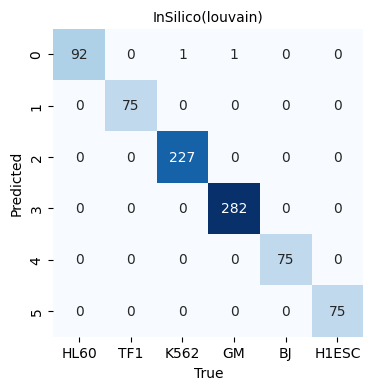

In [15]:
plt.figure(figsize=(4, 4))
sns.heatmap(Cluster_louvain_mat, annot=True, cmap="Blues", fmt='.20g', cbar=False)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title(data_name + '(louvain)', size=10)
plt.savefig('./Results/Louvain confusion mat of ' + data_name + '.svg', bbox_inches='tight')